In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [71]:
%reload_ext autoreload
%autoreload 2
from rnn import MyGRU, MyLSTM, VanillaRNN, RNN
# Download the downsampled data frame from csv-file.
raw_data = pd.read_csv(r'data_example_offsets_new.csv')
raw_data_offsets_removed = raw_data.copy();
raw_data_offsets_removed['Radiator_network_2_temperature'] -= raw_data_offsets_removed['Radiator_network_2_offset']
raw_data_offsets_removed['Ventilation_network_2_temperature'] -= raw_data_offsets_removed['Ventilation_network_2_offset']

seq = 12  # Model input sequence length
fut = 0  # Time of prediction relative to end of model input sequence

# Initialize the model with the required parameters.
hvac_model = MyGRU(y_parameters=['Energy_consumption'], seq=seq, fut=fut, x_parameters=[
    'Outside_humidity',
    'Solar_irradiance',
    'CO2_concentration',
    'hours_sin',
    'hours_cos',
    'weekday_sin',
    'weekday_cos',
    'Domestic_water_network_1_primary_valve',
    'Domestic_water_network_2_primary_valve',
    'District_heat_temperature',
    'Outside_temperature_average',
    'Ventilation_network_1_temperature',
    'Ventilation_network_2_temperature',
    'Radiator_network_1_temperature',
    'Radiator_network_2_temperature'
])

# Scale and split data frame.
df_train, x_train, y_train, df_val, x_val, y_val = hvac_model.preprocess(raw_data)
df_train_offsets_removed, x_train_offsets_removed, y_train_offsets_removed, df_val_offsets_removed, x_val_offsets_removed, y_val_offsets_removed = hvac_model.preprocess(raw_data_offsets_removed)

# Extract dates for predictions
pred_dates_train = hvac_model.get_pred_dates(df_train)
pred_dates_val = hvac_model.get_pred_dates(df_val)


Shape of training data: x: (1545, 12, 15) y: (1545, 1)
Shape of testing data: x: (377, 12, 15) y: (377, 1)
Shape of training data: x: (1545, 12, 15) y: (1545, 1)
Shape of testing data: x: (377, 12, 15) y: (377, 1)


In [72]:
hvac_model.load(r'GRU_Energy_consumption_2022-06-14_trained')

Model loaded.
Scaler loaded.
Other variables loaded.


49/49 [==============================] - 0s 1ms/step


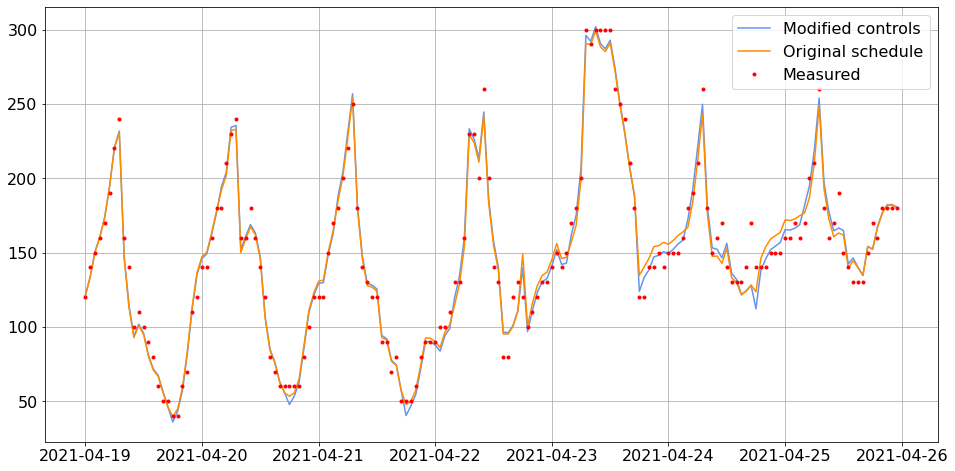

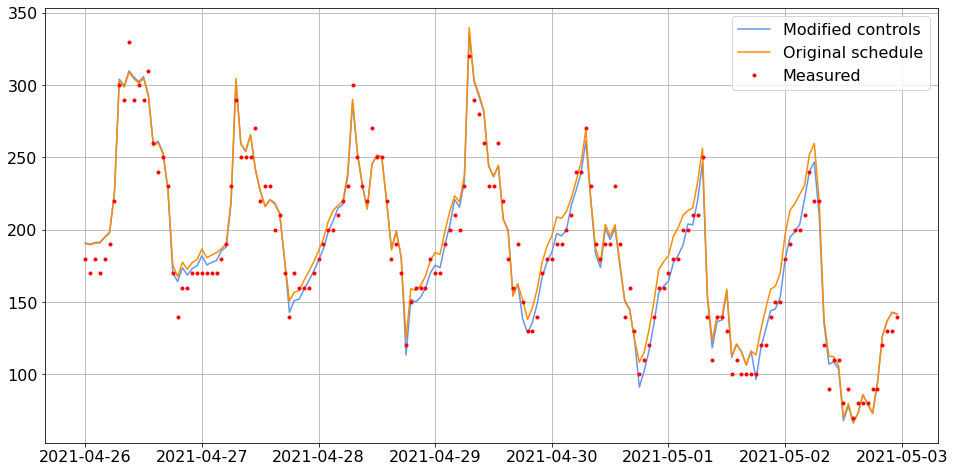

In [74]:
preds, y_scenario = hvac_model.inv_target(x_train, hvac_model.model.predict(x_train), y_train)
preds_offsets_removed, y_offsets_removed = hvac_model.inv_target(x_train_offsets_removed, hvac_model.model.predict(x_train_offsets_removed), y_train_offsets_removed)

plt.rcParams.update({'font.size': 16})

start = 1597-376-12

plt.figure(figsize=(16, 8)) 
plt.plot(pred_dates_train[start:start+24*7], preds[start:start+24*7], label="Modified controls", color="cornflowerblue", marker="")
plt.plot(pred_dates_train[start:start+24*7], preds_offsets_removed[start:start+24*7], label="Original schedule", color="darkorange", marker="")
plt.plot(pred_dates_train[start:start+24*7], y_scenario[start:start+24*7], label="Measured", color="red", marker=".", linestyle="")
plt.legend()
plt.grid(True)
plt.show()

start = 1597-376-12 + 24*7

plt.figure(figsize=(16, 8)) 
plt.plot(pred_dates_train[start:start+24*7], preds[start:start+24*7], label="Modified controls", color="cornflowerblue", marker="")
plt.plot(pred_dates_train[start:start+24*7], preds_offsets_removed[start:start+24*7], label="Original schedule", color="darkorange", marker="")
plt.plot(pred_dates_train[start:start+24*7], y_scenario[start:start+24*7], label="Measured", color="red", marker=".", linestyle="")
plt.legend()
plt.grid(True)
plt.show()